In [ ]:
# get the dataset file (csv)

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [ ]:
# get the first 5 rows of the dataset

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# get info of datatypes in the dataset, no of entries, amt of space taken etc.

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# for categorical data, get the count of each category (and list of distinct categories too for that matter)

housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [ ]:
# get some basic stats on the dataset's numeric values (mean, std, min, max, etc.)

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


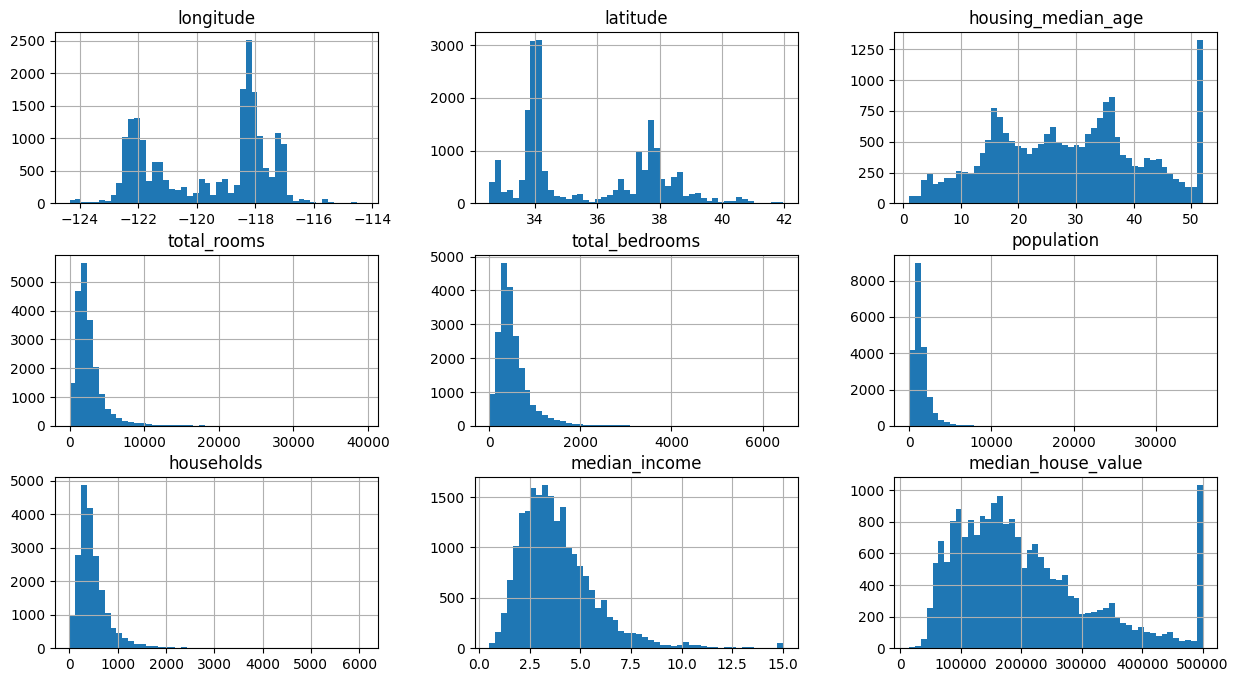

In [13]:
# plot every feature as a histogram
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(15, 8))
plt.show()

In [ ]:

# LIMITATION: 1. shuffling based on indices isn't enough, you need a unique id for each instance in the dataset.
# 2. if you run the code multiple times, you'll get different results.
# 3. if you save the test set (save indices and then use that to retrieve test set), you won't be able to update your test set whenever dataset is updated.

# SOLUTION:
# 1. ideally have a unique identifier for each instance in your dataset.
# 2. create hashes out of all ids, and then for each hash value, if it's less than 20% of the total, put it in the test set. (20% if your test set size = 20% of dataset)

# helper function to divide dataset into training and test sets based on index-shuffling (not ideal)
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [15]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [16]:
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [17]:
# helper function to divide dataset into training and test sets based on hash values (ideal)

from zlib import crc32
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [18]:
housing_with_id = housing.reset_index() # adds an `index` column

In [19]:
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [20]:
# trying to instead create a instance id based on the most stable features in the dataset (latitute and longitude)

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [26]:
# using sklearn's train_test_split function to split the dataset into training and test sets. Use this.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [27]:
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [ ]:
# The above is essentially us sampling our test set using purely random methods... This only works if your dataset is large enough..
# If your dataset is small, you'll end up with a test set that's not representative of the overall dataset (sampling bias)
# refer page 98 of aurelien.

<Axes: >

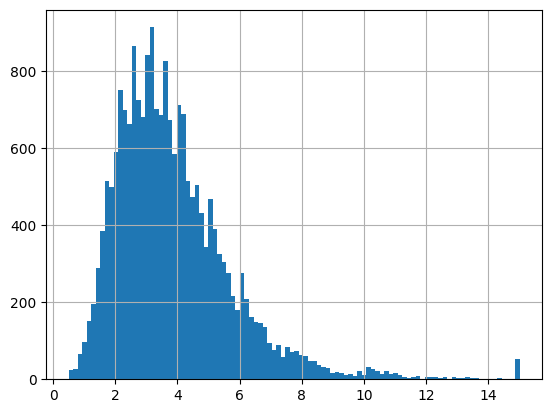

In [ ]:
# In our problem, let's suppose that we got the info that the median income is a very imp attribute to predict median housing price of a district.
# So, we want to make sure that the test set is representative of the various categories of income in the whole dataset.
# To do this, we'll make sure that the test set has a similar proportion of instances per income category as the overall dataset, this we do by adding a new attribute to our dataset, which is a categorical variable made from the median income attribute. This is aka 'Stratified Sampling'
# First, let's look at the median income (a numeric attribute)

housing["median_income"].hist(bins=100)


In [25]:
# let's create the following categories for the median income. You want each strata / category to have roughly the same number of instances, or else the model will be biased towards the strata with less instances.

housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

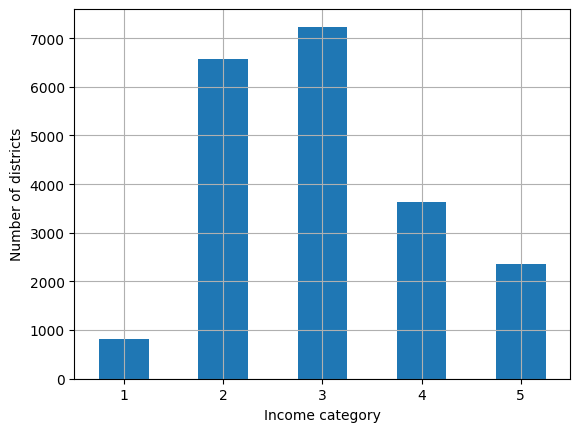

In [28]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()